In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import streamlit as st
import newspaper
from newspaper import Article
import nltk
from nltk.tokenize import word_tokenize
import time
import re
import sklearn
import lightgbm as lgb

In [15]:
nltk.download('punkt', quiet = True)

True

In [16]:
st.set_page_config(page_title = "大阪市 物件過熱度ダッシュボード", layout = "wide")

2025-07-27 22:42:47.371 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [17]:
#不動産データ
try:
    df_pre = pd.read_csv("/home/shizuku/re-voltage/re-voltage/data/raw/used_redata.csv", encoding="932")
    df_pre = df_pre.rename(columns = {"市区町村名" : "area", "取引価格（総額）" : "price", "取引時期" : "year", "最寄駅：距離（分）" : "distance", "建築年" : "built_year", "市区町村コード" : "area_code"})
    df_pre["year"] = df_pre["year"].apply(lambda x:int(re.search(r'\d{4}', str(x)).group()) if re.search(r'\d{4}', str(x)) else None)
    if df_pre["year"].isnull().any():
        st.warning("「year（取引時期）」列に無効な値があります。該当行を削除します。")
        df_pre["year"] = df_pre["year"].astype("int64")
except FileNotFoundError:
    st.error("不動産データが見つかりません！仮データを使用します")
    data = {
        'area': ['大阪市中央区', '大阪市中央区', '大阪市北区', '大阪市北区', '大阪市天王寺区', '大阪市天王寺区', '大阪市福島区', '大阪市福島区'],
        '取引価格（総額）': [7500, 9000, 6500, 7800, 6000, 6800, 5000, 5500], 
        '取引時期': [2020, 2024, 2020, 2024, 2020, 2024, 2020, 2024], 
        '最寄駅：距離（分）': [3, 3, 4, 4, 5, 5, 4, 4], 
        '建築年': [2010, 2010, 2008, 2008, 2005, 2005, 2000, 2000]
    }
    df_pre = pd.DataFrame(data)

/tmp/ipykernel_117676/2995974502.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pre = pd.read_csv("/home/shizuku/re-voltage/re-voltage/data/raw/used_redata.csv", encoding="932")


In [36]:
df_demo = pd.read_csv("/home/shizuku/re-voltage/re-voltage/data/raw/used_demodata.csv", encoding="932")

In [27]:
df_demo.head()

,時間軸(年次) コード,時間軸(年次) 補助コード,時間軸(年次),都道府県・市部－郡部－市区町村別 コード,都道府県・市部－郡部－市区町村別 補助コード,都道府県・市部－郡部－市区町村別,/人口動態総覧,出生数【人】,2500g未満出生数【人】,死亡数【人】,乳児（１歳未満）死亡数【人】,新生児（生後4週未満）死亡数【人】,自然死産数【胎】,人工死産数【胎】,周産期死亡数【胎・人】,妊娠満22週以後の死産数【胎】,早期新生児（生後1週未満）死亡数【人】,婚姻件数【組】,離婚件数【組】
0,2023000000,NaN,2023年,1000,NaN,北海道,NaN,"24,430","2,468","75,120",38,19,261,374,89,72,17,"17,281","8,629"
1,2023000000,NaN,2023年,1020,NaN,その他の市,NaN,"10,373","1,012","35,925",15,9,113,167,38,29,9,"7,033","3,846"
2,2023000000,NaN,2023年,1030,NaN,郡部,NaN,"3,705",361,"15,352",5,3,43,38,13,10,3,"2,340","1,225"
3,2023000000,NaN,2023年,1010,NaN,札幌市,NaN,"10,352","1,095","23,843",18,7,105,169,38,33,5,"7,908","3,558"
4,2023000000,NaN,2023年,1101,NaN,中央区,NaN,"1,332",150,"2,684",2,-,13,39,4,4,-,"1,344",527


In [ ]:
df_demo = df_demo.replace("-" , "0")
df_demo = df_demo.rename(columns = {"都道府県・市部－郡部－市区町村別 コード" : "area_code"})
df_demo["year"] = df_demo["時間軸(年次) コード"].astype(str).str[:4]
df_demo.head()

,時間軸(年次) コード,時間軸(年次) 補助コード,時間軸(年次),area_code,都道府県・市部－郡部－市区町村別 補助コード,都道府県・市部－郡部－市区町村別,/人口動態総覧,出生数【人】,2500g未満出生数【人】,死亡数【人】,乳児（１歳未満）死亡数【人】,新生児（生後4週未満）死亡数【人】,自然死産数【胎】,人工死産数【胎】,周産期死亡数【胎・人】,妊娠満22週以後の死産数【胎】,早期新生児（生後1週未満）死亡数【人】,婚姻件数【組】,離婚件数【組】,year
0,2023000000,NaN,2023年,1000,NaN,北海道,NaN,"24,430","2,468","75,120",38,19,261,374,89,72,17,"17,281","8,629",2023
1,2023000000,NaN,2023年,1020,NaN,その他の市,NaN,"10,373","1,012","35,925",15,9,113,167,38,29,9,"7,033","3,846",2023
2,2023000000,NaN,2023年,1030,NaN,郡部,NaN,"3,705",361,"15,352",5,3,43,38,13,10,3,"2,340","1,225",2023
3,2023000000,NaN,2023年,1010,NaN,札幌市,NaN,"10,352","1,095","23,843",18,7,105,169,38,33,5,"7,908","3,558",2023
4,2023000000,NaN,2023年,1101,NaN,中央区,NaN,"1,332",150,"2,684",2,0,13,39,4,4,0,"1,344",527,2023


In [ ]:
df_demo["year"] = df_demo["year"].astype('int64')

In [45]:
df_redemo = df_pre.merge(df_demo, on = ["area_code", "year"], how = 'left')

In [ ]:
df_redemo = df_redemo.dropna(subset=["離婚件数【組】"])

In [67]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X = df_redemo.loc[:, (df_redemo.columns!="price")]
cat_cols = X.select_dtypes(include=['object', 'category']).columns
X[cat_cols] = X[cat_cols].astype(str)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
X = X.astype({col: 'float32' for col in X.select_dtypes('bool').columns})
nunique = X.nunique()
useful_cols = nunique[nunique > 1].index
X = X[useful_cols]

y = df_redemo["price"]
y = np.log1p(y)

/tmp/ipykernel_117676/3106730793.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].astype(str)
/tmp/ipykernel_117676/3106730793.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = encoder.fit_transform(X[cat_cols])


In [59]:
print(X)

         種類  価格情報区分  area_code  都道府県名  area     地区名  最寄駅：名称  distance   間取り  \
0       0.0     1.0      27102    0.0  35.0  1283.0   139.0       5.0  18.0   
1       0.0     1.0      27102    0.0  35.0   213.0   397.0       3.0  26.0   
2       0.0     1.0      27102    0.0  35.0   412.0   394.0       NaN  26.0   
3       0.0     1.0      27102    0.0  35.0   412.0   394.0       5.0  26.0   
4       0.0     1.0      27102    0.0  35.0   412.0   394.0       5.0  36.0   
...     ...     ...        ...    ...   ...     ...     ...       ...   ...   
142217  0.0     0.0      27366    0.0  53.0  1098.0   307.0      10.0  26.0   
142218  0.0     0.0      27366    0.0  53.0  1098.0   307.0       8.0   8.0   
142219  0.0     0.0      27366    0.0  53.0  1098.0   307.0       8.0  26.0   
142223  0.0     0.0      27366    0.0  53.0  1098.0   307.0      10.0   8.0   
142225  0.0     0.0      27366    0.0  53.0  1098.0     7.0       3.0  26.0   

        面積（㎡）  ...  死亡数【人】  乳児（１歳未満）死亡数【人】  新生児（生後4

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [71]:
model = lgb.LGBMRegressor(boosting_type='gbdt', max_depth=5, random_state=0, n_estimators=1000, verbose=-1)

In [72]:
eval_set = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation)
model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[651]	valid_0's l2: 0.0649103


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.1
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("R2  :", r2_score(y_test, y_pred))

RMSE: 0.06491026733839278
MAE : 0.1639388563414553
R2  : 0.8643796225161466


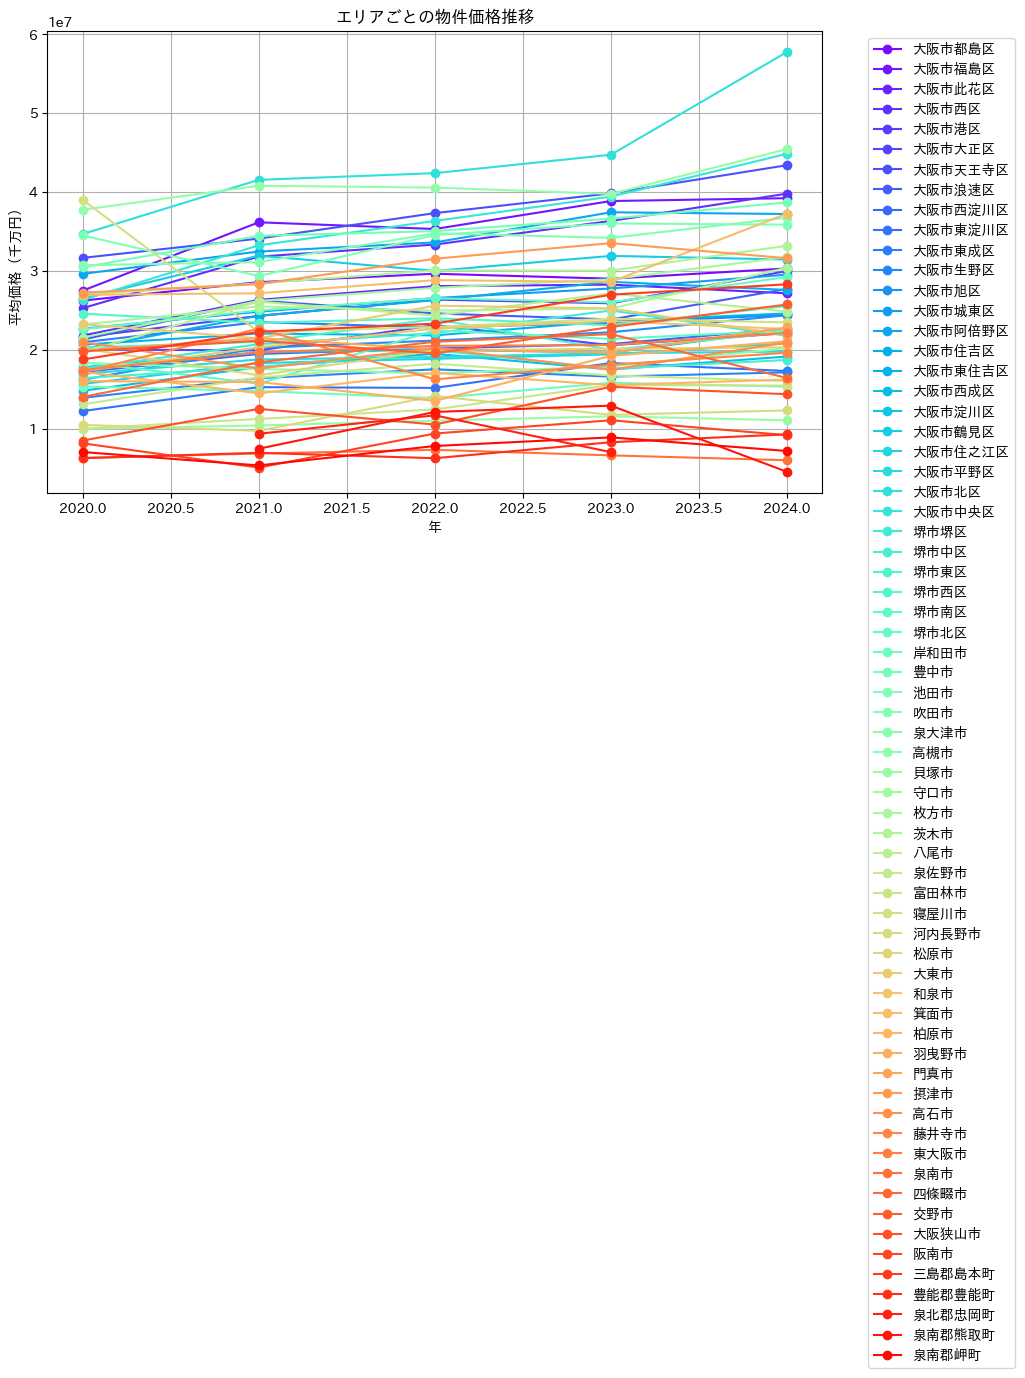

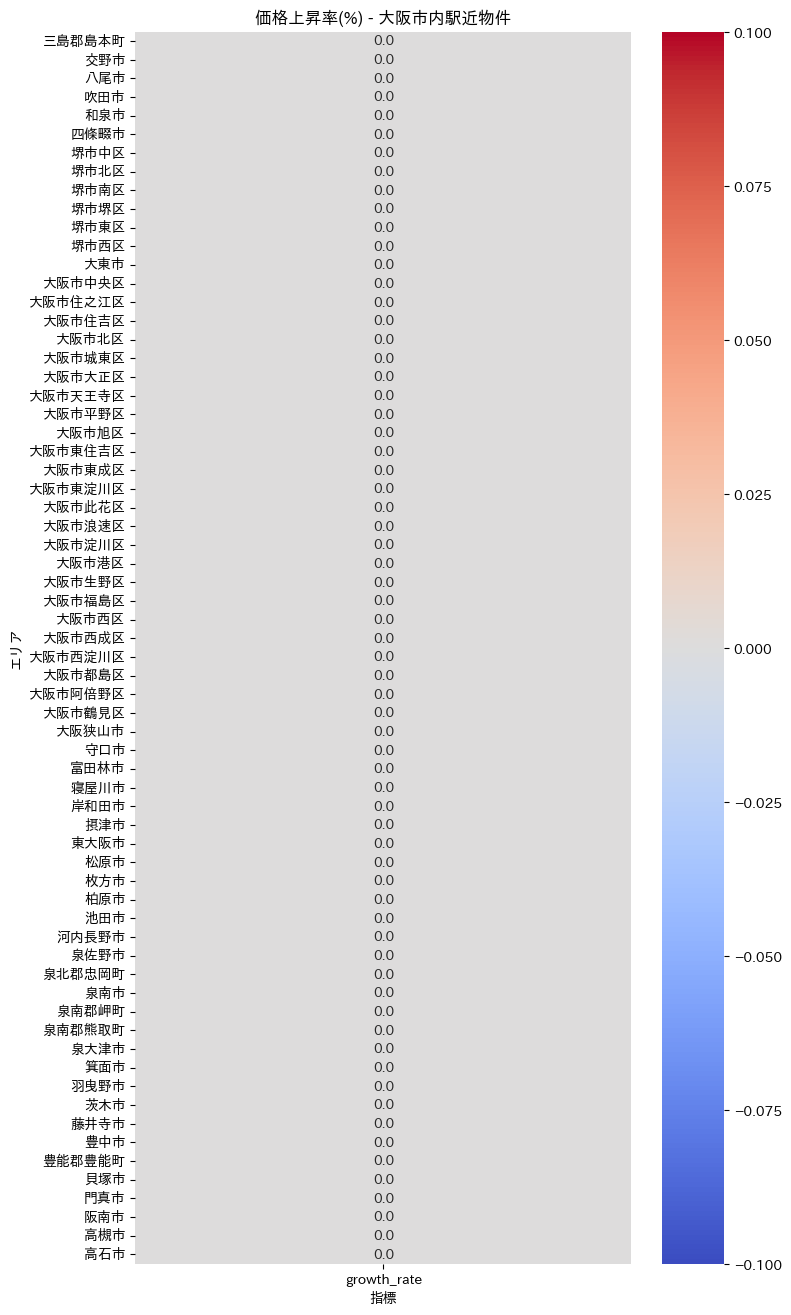

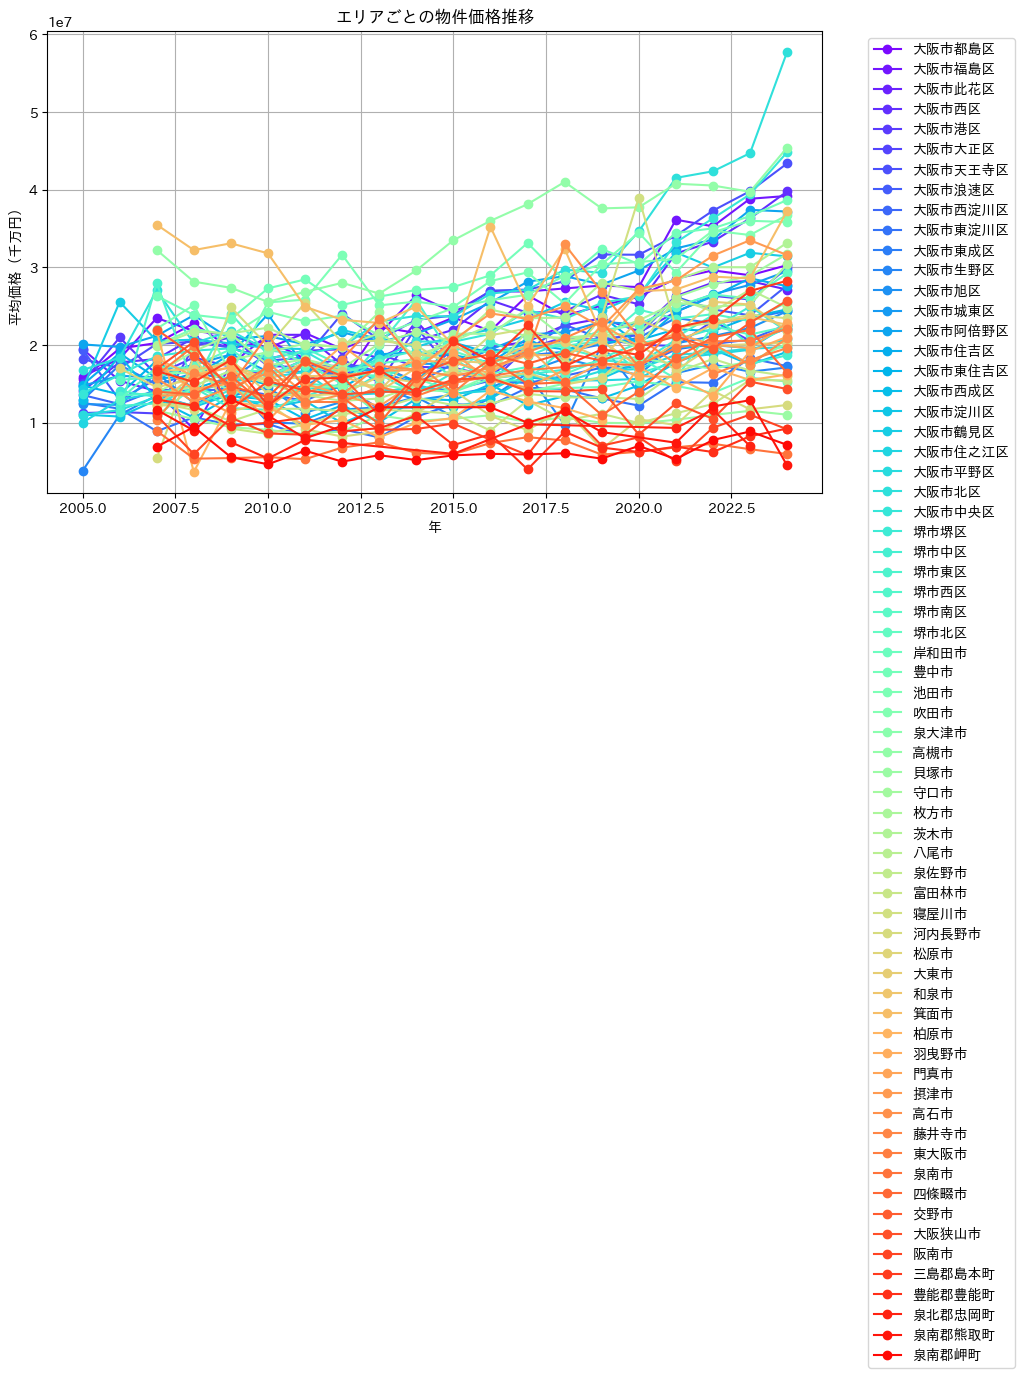

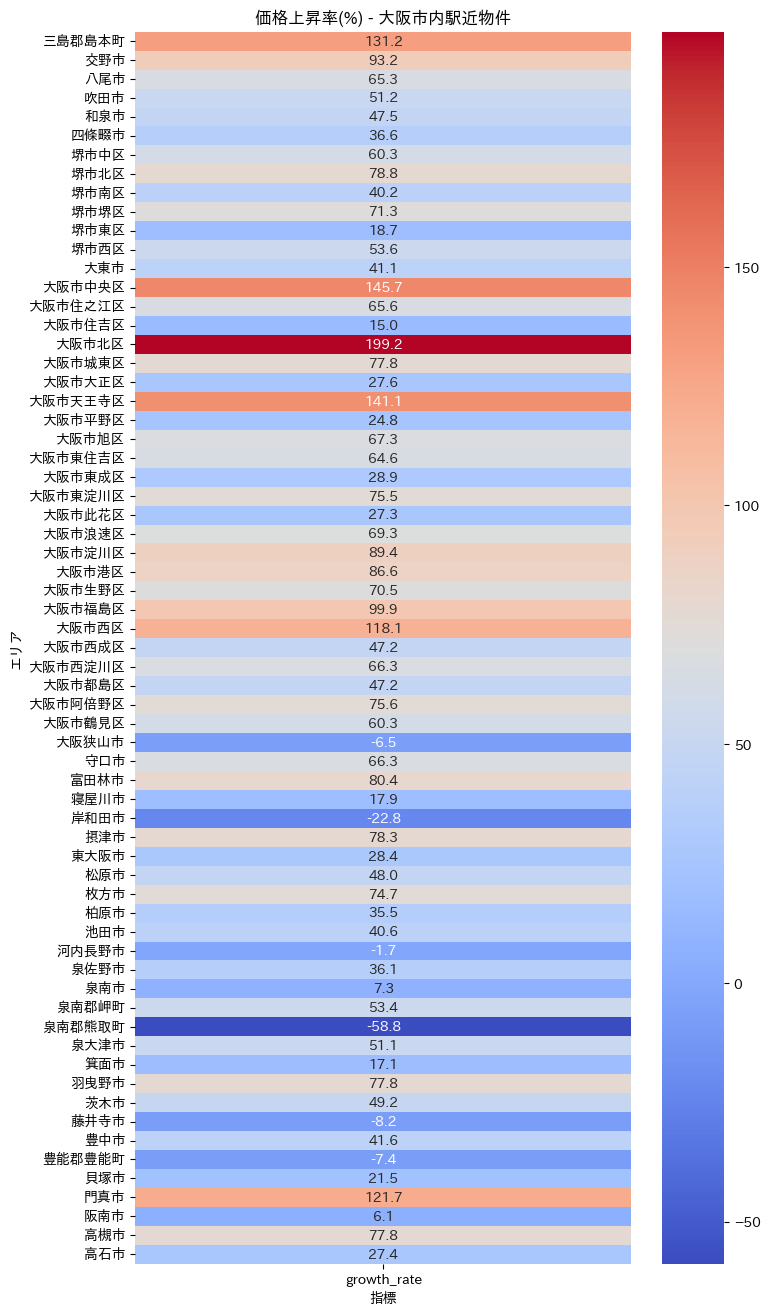

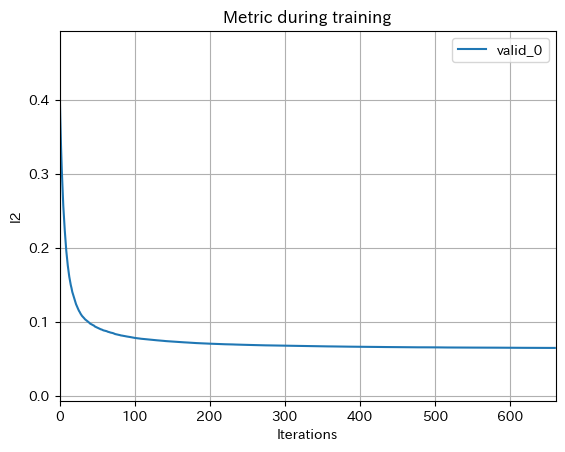

In [76]:
plt.show(lgb.plot_metric(model))

<Figure size 1500x1500 with 0 Axes>

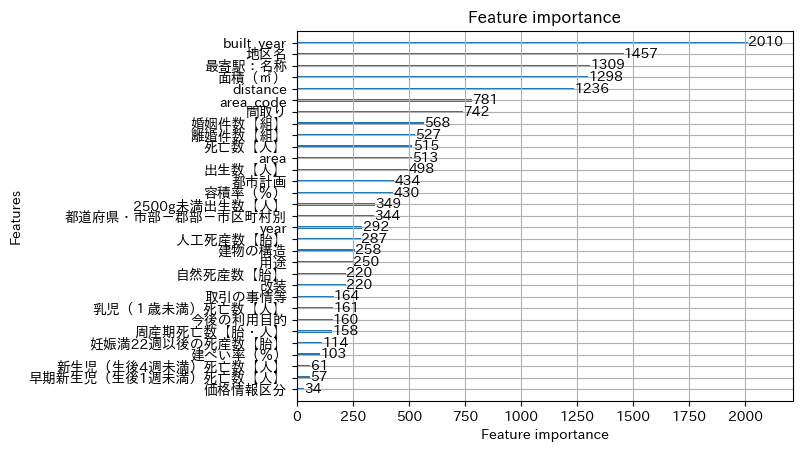

In [80]:
plt.figure(figsize=(15, 15))
lgb.plot_importance(model)
plt.show()

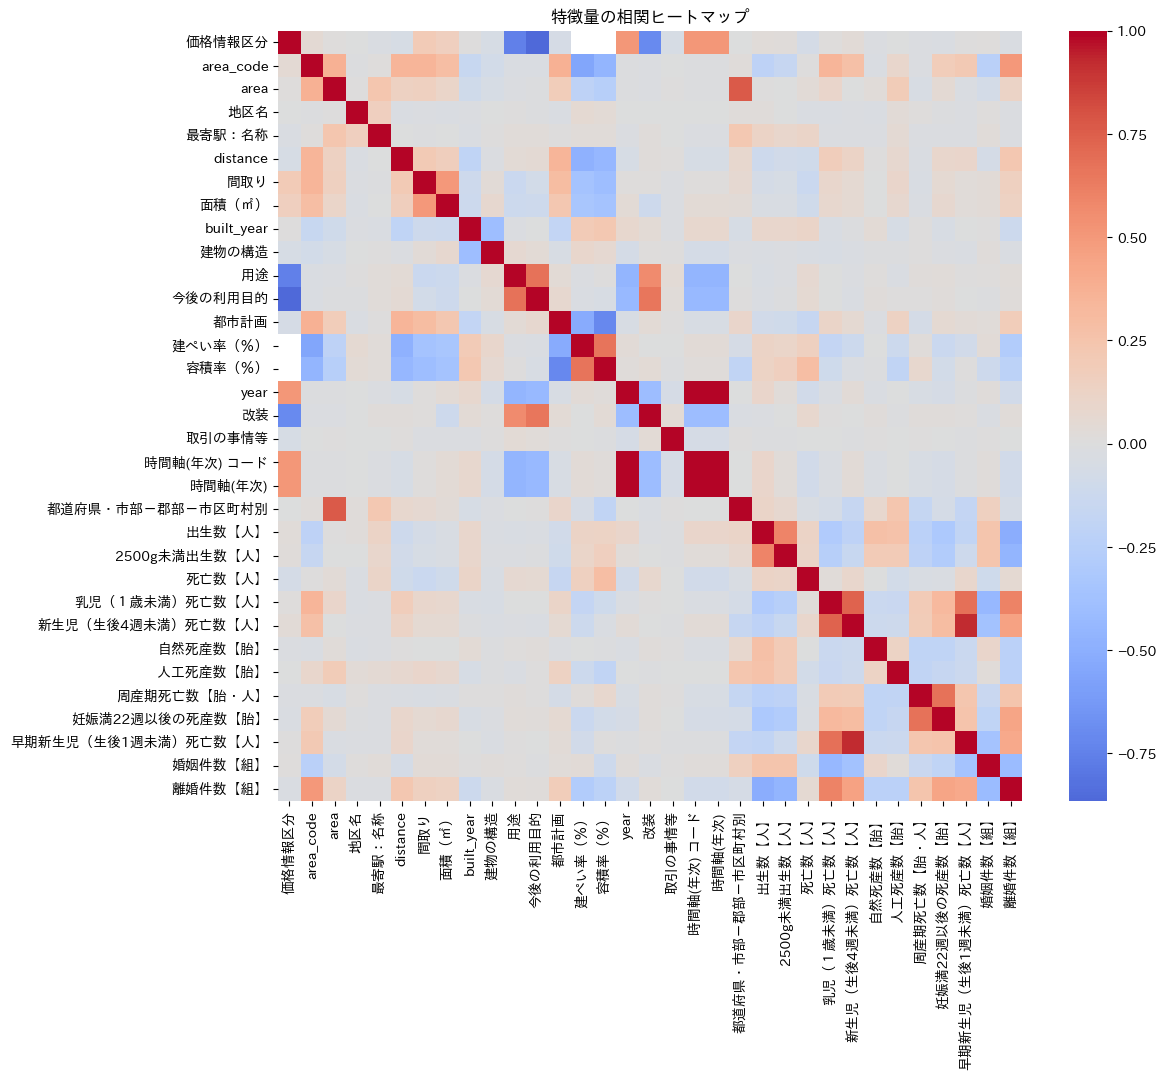

In [81]:
corr_matrix = X.select_dtypes(include='number').corr()

# 相関行列のヒートマップ表示
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('特徴量の相関ヒートマップ')
plt.show()


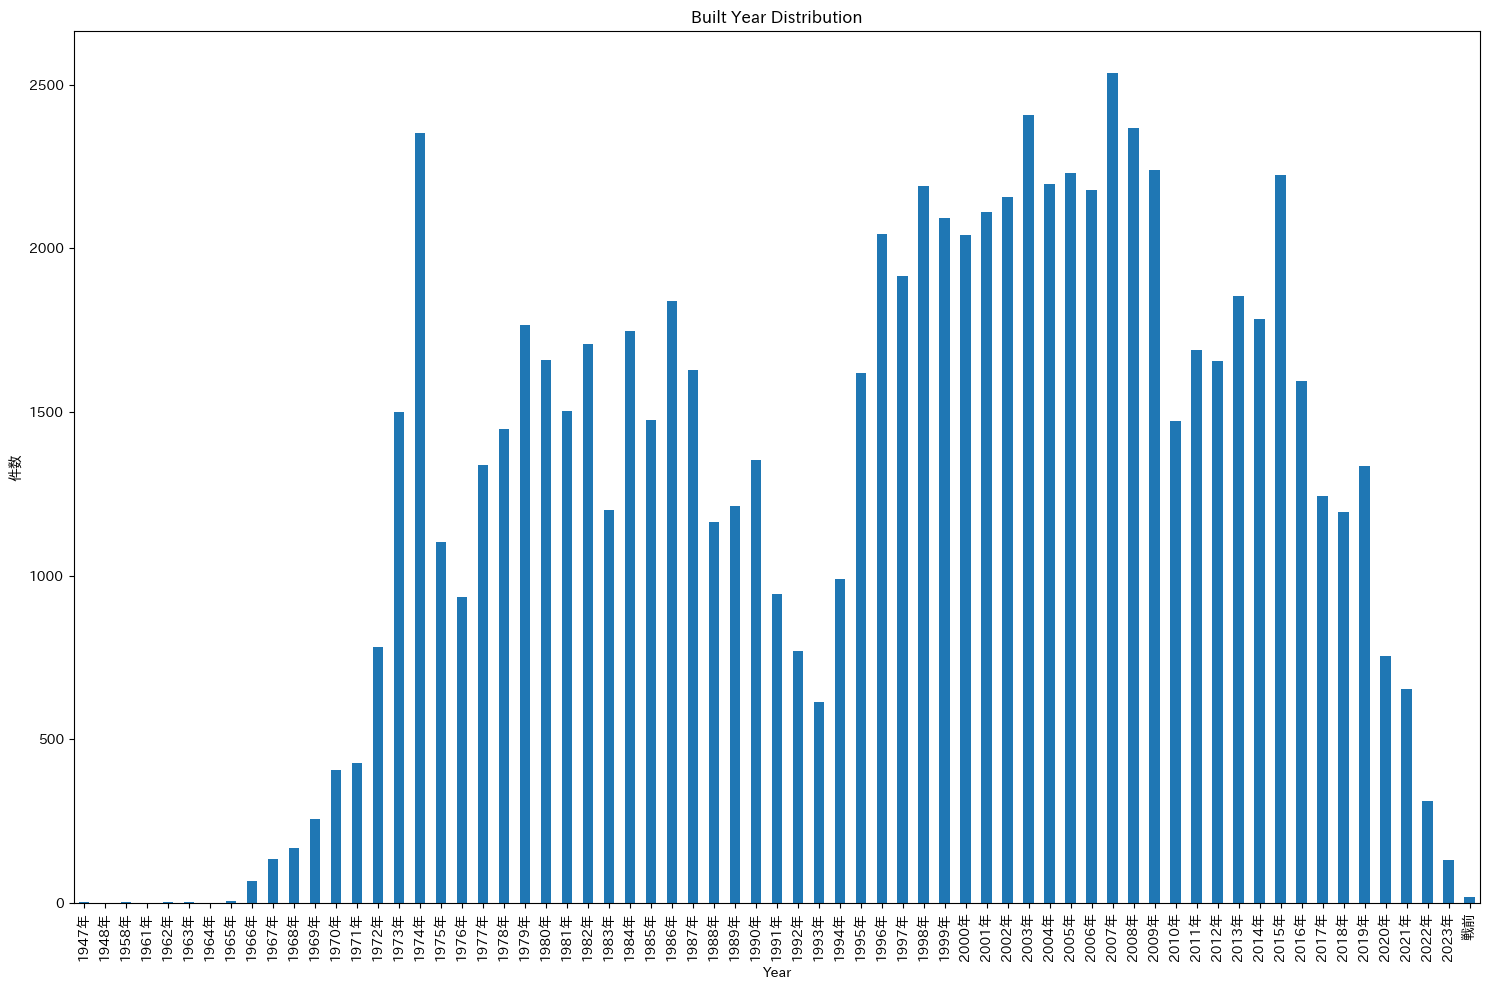

In [85]:
# built_yearの分布（ヒストグラム）
# built_yearのユニークな値を昇順に取得
sorted_years = sorted(df_redemo['built_year'].dropna().unique())

# 年代ごとの件数を集計して並び替え
year_counts = df_redemo['built_year'].value_counts().reindex(sorted_years)

plt.figure(figsize=(15,10))
year_counts.plot(kind='bar')
plt.title('Built Year Distribution')
plt.xlabel('Year')
plt.ylabel('件数')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
